In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.insert(0, '../src')

In [3]:
import torch
from pytorch3d.datasets import R2N2, collate_batched_R2N2, BlenderCamera
from pytorch3d.structures import Pointclouds
from pytorch3d.utils import ico_sphere
from pytorch3d.renderer import (
    FoVOrthographicCameras,
    PointsRasterizationSettings,
    RasterizationSettings,
    PointsRasterizer,
    PointsRenderer,
    PointLights,
    AlphaCompositor,
    NormWeightedCompositor,
)
from dataloader import build_data_loader
import utils

In [4]:
ptcld_gt = torch.load('../results/baseline/02828884-cae6c2b329bbc12de5d5fc930770c792-16_gt.pth')

In [5]:
ptcld_gt.shape

torch.Size([32, 10000, 3])

In [4]:
test_loader = build_data_loader(
        data_dir='/home/data/ShapeNet/ShapeNetV1processed/',
        split_name='test',
        splits_file='../data/bench_splits.json',
        batch_size=32,
        num_workers=4,
        multigpu=False,
        shuffle=True,
        num_samples=None
    )

In [5]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
sigma = 1e-4

def render_points(points, R, T, K):
    ptclds = Pointclouds(points, features=torch.ones_like(points)).to('cuda')
    '''
    camera = BlenderCamera(device=DEVICE, R=R, T=T, K=K)
    raster_settings = PointsRasterizationSettings(
        image_size=137,
        radius = 0.01,
        points_per_pixel = 10
    )
    rasterizer = PointsRasterizer(
        cameras=camera,
        raster_settings=raster_settings
    )
    compositor = AlphaCompositor()

    textured_fragments = rasterizer(ptclds)
    textured_probs = (-textured_fragments.dists / sigma).sigmoid()
    images = compositor(
        textured_fragments.idx.long().permute(0, 3, 1, 2),
        textured_probs.permute(0, 3, 1, 2),
        ptclds.features_packed().permute(1, 0)
    )  # (N, C, H, W)
    
    renderer = PointsRenderer(rasterizer=rasterizer, compositor=)
    '''
    camera = BlenderCamera(device='cuda', R=R[None, :], T=T[None, :], K=K[None, :])
    renderer = PointsRenderer(
        rasterizer=PointsRasterizer(
            cameras=camera, 
            raster_settings=PointsRasterizationSettings(image_size=137)
        ),
        compositor=NormWeightedCompositor()
    )
    images = renderer(ptclds, cameras=camera, lights=PointLights())  # (N, H, W, C)

    return images

In [12]:
from utils import compute_camera_calibration, rotate_verts, format_image, get_blender_intrinsic_matrix
for batch_idx, batch in enumerate(test_loader):
    images, _, ptclds_gt, normals, RT, K, id_strs = test_loader.postprocess(batch)
    
    rot = torch.tensor([[0, -1, 0, 0], [0, 0, 1, 0], [1, 0, 0, 0], [0, 0, 0, 1]], device=DEVICE)
    ptclds_gt_cam = rotate_verts(rot.to(RT).unsqueeze(0).repeat(32, 1, 1), ptclds_gt)
    
    print(RT.shape)
    print("ptclds_gt: ", ptclds_gt.shape)
    R, T = compute_camera_calibration(RT[0].cpu())
    R = R.to(DEVICE)
    T = T.to(DEVICE)
    print("R: ", R.shape)
    print("T: ", T.shape)
    print("K: ", K.shape)
    print(K[0].shape)
    #print(ptclds_gt.shape)
    
    ptcld_img = render_points(ptclds_gt_cam[0].reshape(1,10000,3), R, T, K[0]) #(N, C, H, W)
    img = images[0]
    
    break

torch.Size([32, 4, 4])
ptclds_gt:  torch.Size([32, 10000, 3])
R:  torch.Size([3, 3])
T:  torch.Size([3])
K:  torch.Size([32, 4, 4])
torch.Size([4, 4])
torch.Size([3, 137, 137])


torch.Size([1, 137, 137, 3])


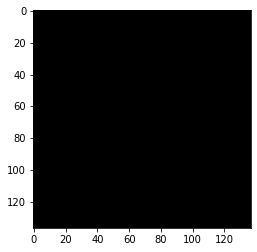

In [13]:
import matplotlib.pyplot as plt

print(ptcld_img.shape)
plt.imshow(ptcld_img.squeeze(0).detach().cpu().numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


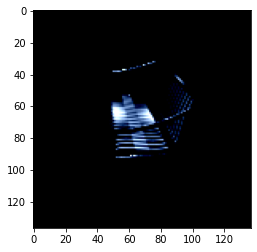

In [41]:
img2 = img.permute(1,2,0)
plt.imshow(img2.detach().cpu().numpy())

In [22]:
import os
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from skimage.io import imread

# Util function for loading point clouds|
import numpy as np

# Data structures and functions for rendering
from pytorch3d.structures import Pointclouds
from pytorch3d.utils import ico_sphere
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVOrthographicCameras, 
    PointsRasterizationSettings,
    PointsRenderer,
    PulsarPointsRenderer,
    PointsRasterizer,
    AlphaCompositor,
    NormWeightedCompositor,
    PointLights,
    SoftPhongShader
)


In [23]:
!mkdir -p ../data/PittsburghBridge
!wget -P ../data/PittsburghBridge https://dl.fbaipublicfiles.com/pytorch3d/data/PittsburghBridge/pointcloud.npz

--2021-05-13 23:56:14--  https://dl.fbaipublicfiles.com/pytorch3d/data/PittsburghBridge/pointcloud.npz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 172.67.9.4, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5701352 (5.4M) [application/zip]
Saving to: ‘../data/PittsburghBridge/pointcloud.npz’

pointcloud.npz      100%[===================>]   5.44M  20.2MB/s    in 0.3s    

2021-05-13 23:56:15 (20.2 MB/s) - ‘../data/PittsburghBridge/pointcloud.npz’ saved [5701352/5701352]



In [24]:
# Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

# Set paths
DATA_DIR = "../data"
obj_filename = os.path.join(DATA_DIR, "PittsburghBridge/pointcloud.npz")

# Load point cloud
pointcloud = np.load(obj_filename)
verts = torch.Tensor(pointcloud['verts']).to(device)
        
rgb = torch.Tensor(pointcloud['rgb']).to(device)

point_cloud = Pointclouds(points=[verts], features=[rgb])

In [3]:
point_cloud.__dict__


{'device': device(type='cuda', index=0),
 'equisized': True,
 'valid': tensor([True], device='cuda:0'),
 '_N': 1,
 '_P': 438544,
 '_C': 4,
 '_points_list': [tensor([[ 0.8581, -0.5629,  1.4595],
          [ 0.8503, -0.5697,  1.4450],
          [ 0.8562, -0.5683,  1.4633],
          ...,
          [ 0.1044, -0.5574,  2.2271],
          [ 0.0731, -0.5582,  2.2246],
          [ 0.0712, -0.5622,  2.2249]], device='cuda:0')],
 '_normals_list': None,
 '_features_list': [tensor([[0.5703, 0.5977, 0.5781, 0.9961],
          [0.5938, 0.6172, 0.6016, 0.9961],
          [0.5781, 0.6016, 0.5820, 0.9961],
          ...,
          [0.5430, 0.5625, 0.5391, 0.9961],
          [0.5430, 0.5547, 0.5312, 0.9961],
          [0.5469, 0.5586, 0.5391, 0.9961]], device='cuda:0')],
 '_num_points_per_cloud': tensor([438544], device='cuda:0'),
 '_points_packed': None,
 '_normals_packed': None,
 '_features_packed': None,
 '_packed_to_cloud_idx': None,
 '_cloud_to_packed_first_idx': None,
 '_points_padded': None,
 '_

In [25]:
point_cloud._points_list[0].shape


torch.Size([438544, 3])

In [27]:
# Initialize a camera.
R, T = look_at_view_transform(20, 10, 0)
print("R SHAPE: ", R.shape)
print("T SHAPE: ", T.shape)
cameras = FoVOrthographicCameras(device=device, R=R, T=T, znear=0.01)

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
# and blur_radius=0.0. Refer to raster_points.py for explanations of these parameters. 
raster_settings = PointsRasterizationSettings(
    image_size=512, 
    radius = 0.003,
    points_per_pixel = 10
)


# Create a points renderer by compositing points using an alpha compositor (nearer points
# are weighted more heavily). See [1] for an explanation.
rasterizer = PointsRasterizer(cameras=cameras, raster_settings=raster_settings)
renderer = PointsRenderer(
    rasterizer=rasterizer,
    compositor=AlphaCompositor()
)

R SHAPE:  torch.Size([1, 3, 3])
T SHAPE:  torch.Size([1, 3])


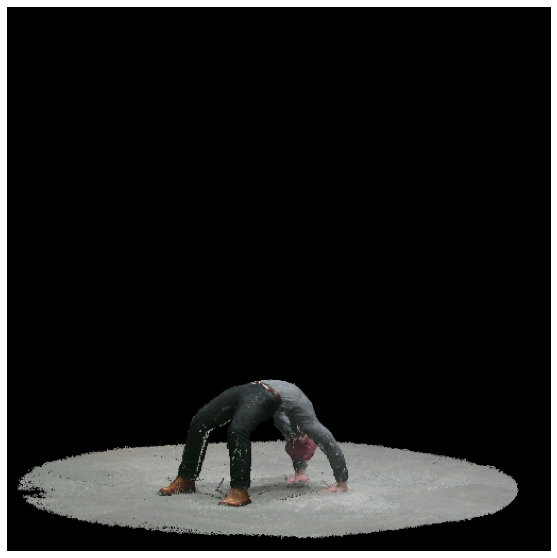

In [8]:
images = renderer(point_cloud)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off")
plt.axis("off");

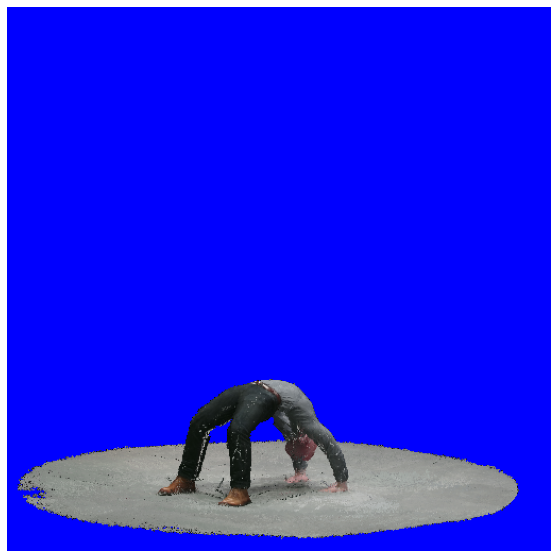

In [9]:
renderer = PointsRenderer(
    rasterizer=rasterizer,
    # Pass in background_color to the alpha compositor, setting the background color 
    # to the 3 item tuple, representing rgb on a scale of 0 -> 1, in this case blue
    compositor=AlphaCompositor(background_color=(0, 0, 1))
)
images = renderer(point_cloud)

plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off")
plt.axis("off");

# Silhouette

In [23]:
# the number of different viewpoints from which we want to render the mesh.
num_views = 20

# Get a batch of viewing angles. 
elev = torch.linspace(0, 360, num_views)
azim = torch.linspace(-180, 180, num_views)

# Place a point light in front of the object. As mentioned above, the front of 
# the cow is facing the -z direction. 
lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

# Initialize an OpenGL perspective camera that represents a batch of different 
# viewing angles. All the cameras helper methods support mixed type inputs and 
# broadcasting. So we can view the camera from the a distance of dist=2.7, and 
# then specify elevation and azimuth angles for each viewpoint as tensors. 
R, T = look_at_view_transform(dist=2.7, elev=elev, azim=azim)
cameras = FoVOrthographicCameras(device=device, R=R, T=T)

# We arbitrarily choose one particular view that will be used to visualize 
# results
camera = FoVOrthographicCameras(device=device, R=R[None, 1, ...], 
                                  T=T[None, 1, ...]) 

# Define the settings for rasterization and shading. Here we set the output 
# image to be of size 128X128. As we are rendering images for visualization 
# purposes only we will set faces_per_pixel=1 and blur_radius=0.0. Refer to 
# rasterize_meshes.py for explanations of these parameters.  We also leave 
# bin_size and max_faces_per_bin to their default values of None, which sets 
# their values using heuristics and ensures that the faster coarse-to-fine 
# rasterization method is used.  Refer to docs/notes/renderer.md for an 
# explanation of the difference between naive and coarse-to-fine rasterization. 
raster_settings = PointsRasterizationSettings(
    image_size=512, 
    radius = 0.003,
    points_per_pixel = 10
)

# Create a Phong renderer by composing a rasterizer and a shader. The textured 
# Phong shader will interpolate the texture uv coordinates for each vertex, 
# sample from a texture image and apply the Phong lighting model
renderer = PointsRenderer(
    rasterizer=PointsRasterizer(
        cameras=camera, 
        raster_settings=raster_settings
    ),
    compositor=AlphaCompositor()
)

# Create a batch of meshes by repeating the cow mesh and associated textures. 
# Meshes has a useful `extend` method which allows us do this very easily. 
# This also extends the textures. 
point_clouds = point_cloud.extend(num_views)

# Render the cow mesh from each viewing angle
target_images = renderer(point_clouds, cameras=cameras, lights=lights)

# Our multi-view cow dataset will be represented by these 2 lists of tensors,
# each of length num_views.
target_rgb = [target_images[i, ..., :3] for i in range(num_views)]
target_cameras = [FoVOrthographicCameras(device=device, R=R[None, i, ...], 
                                           T=T[None, i, ...]) for i in range(num_views)]

In [28]:
silhouette_images = renderer(point_clouds, cameras=cameras, lights=lights)
target_silhouette = [silhouette_images[i, ..., 3] for i in range(num_views)]

In [30]:
# Show a visualization comparing the rendered predicted mesh to the ground truth 
# mesh
def visualize_prediction(predicted_mesh, renderer=renderer, 
                         target_image=target_rgb[1], title='', 
                         silhouette=False):
    inds = 3 if silhouette else range(3)
    with torch.no_grad():
        predicted_images = renderer(predicted_mesh)
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(predicted_images[0, ..., inds].cpu().detach().numpy())

    plt.subplot(1, 2, 2)
    plt.imshow(target_image.cpu().detach().numpy())
    plt.title(title)
    plt.axis("off")

# Plot losses as a function of optimization iteration
def plot_losses(losses):
    fig = plt.figure(figsize=(13, 5))
    ax = fig.gca()
    for k, l in losses.items():
        ax.plot(l['values'], label=k + " loss")
    ax.legend(fontsize="16")
    ax.set_xlabel("Iteration", fontsize="16")
    ax.set_ylabel("Loss", fontsize="16")
    ax.set_title("Loss vs iterations", fontsize="16")

In [33]:
# We initialize the source shape to be a sphere of radius 1.  
src_mesh = ico_sphere(4, device)

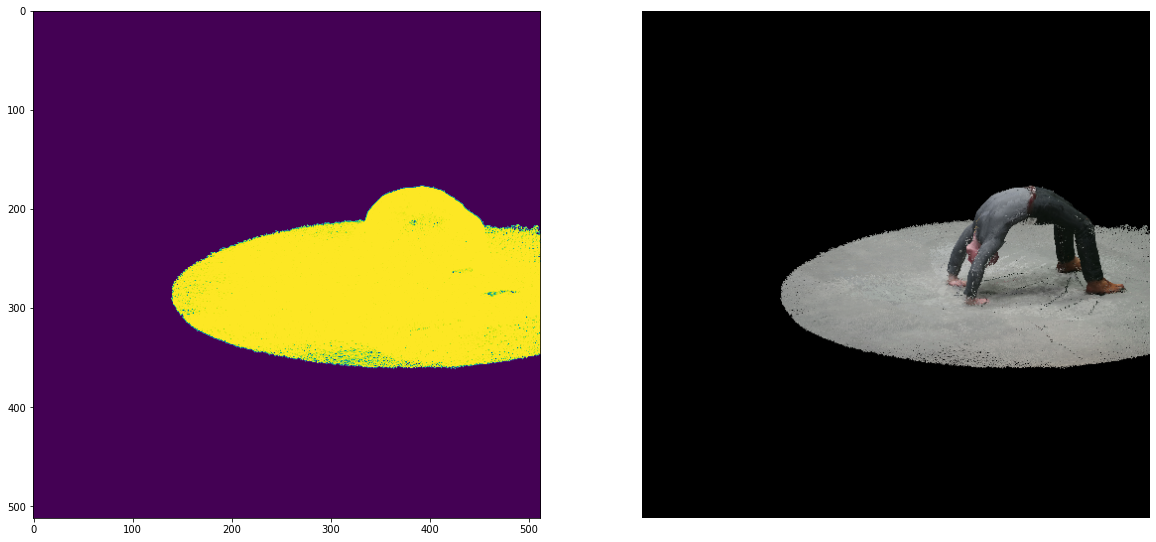

In [35]:
visualize_prediction(point_clouds, renderer, silhouette=True)

In [36]:
silhouette_images

tensor([[[[0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000]],

         ...,

         [[0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000],
          

In [41]:
R, T = look_at_view_transform(20, 10, 0)
print(R.shape)
print(T.shape)

cameras = FoVOrthographicCameras(device=device, R=R, T=T, znear=0.01)
cameras.__dict__.keys()

torch.Size([1, 3, 3])
torch.Size([1, 3])


dict_keys(['training', '_parameters', '_buffers', '_non_persistent_buffers_set', '_backward_hooks', '_forward_hooks', '_forward_pre_hooks', '_state_dict_hooks', '_load_state_dict_pre_hooks', '_modules', 'device', '_N', 'K', 'znear', 'zfar', 'max_y', 'min_y', 'max_x', 'min_x', 'scale_xyz', 'R', 'T'])